<a href="https://colab.research.google.com/github/peterbabulik/QuantumMaterialsGenerator/blob/main/QuantumMaterialsGenerator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
pip install cirq

  Using cached cirq-1.4.1-py3-none-any.whl.metadata (7.4 kB)
  Using cached cirq_aqt-1.4.1-py3-none-any.whl.metadata (1.6 kB)
  Using cached cirq_core-1.4.1-py3-none-any.whl.metadata (1.8 kB)
  Using cached cirq_google-1.4.1-py3-none-any.whl.metadata (2.0 kB)
  Using cached cirq_ionq-1.4.1-py3-none-any.whl.metadata (1.6 kB)
  Using cached cirq_pasqal-1.4.1-py3-none-any.whl.metadata (1.6 kB)
  Using cached cirq_rigetti-1.4.1-py3-none-any.whl.metadata (1.7 kB)
  Using cached cirq_web-1.4.1-py3-none-any.whl.metadata (2.6 kB)
  Using cached duet-0.2.9-py3-none-any.whl.metadata (2.3 kB)
  Using cached sortedcontainers-2.4.0-py2.py3-none-any.whl.metadata (10 kB)
  Using cached pyquil-4.14.3-py3-none-any.whl.metadata (10 kB)
  Using cached packaging-23.2-py3-none-any.whl.metadata (3.2 kB)
  Using cached qcs_sdk_python-0.20.1-cp310-cp310-manylinux_2_28_x86_64.whl.metadata (7.0 kB)
  Using cached quil-0.13.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using ca

In [5]:

import cirq
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import tensorflow as tf

class QuantumMaterialsML:
    def __init__(self, n_qubits, n_properties):
        """
        Initialize the quantum-classical hybrid model for materials discovery.

        Args:
            n_qubits: Number of qubits to use in quantum circuit
            n_properties: Number of material properties to predict
        """
        self.n_qubits = n_qubits
        self.n_properties = n_properties
        self.qubits = cirq.LineQubit.range(n_qubits)
        self.circuit = None

    def create_quantum_circuit(self):
        """Create a parameterized quantum circuit for encoding material features"""
        circuit = cirq.Circuit()

        # Initial superposition
        circuit.append(cirq.H.on_each(self.qubits))

        # Parameterized rotation layers
        self.params = []
        for i in range(self.n_qubits):
            param_x = sympy.Symbol(f'θ_{i}_x')
            param_y = sympy.Symbol(f'θ_{i}_y')
            param_z = sympy.Symbol(f'θ_{i}_z')
            self.params.extend([param_x, param_y, param_z])

            circuit.append([
                cirq.rx(param_x)(self.qubits[i]),
                cirq.ry(param_y)(self.qubits[i]),
                cirq.rz(param_z)(self.qubits[i])
            ])

        # Entangling layers
        for i in range(self.n_qubits - 1):
            circuit.append(cirq.CNOT(self.qubits[i], self.qubits[i + 1]))

        self.circuit = circuit
        return circuit

    def encode_material_features(self, features):
        """
        Encode classical material features into quantum circuit parameters

        Args:
            features: Array of material features to encode
        """
        # Normalize features to [-π, π] range
        scaler = StandardScaler()
        normalized_features = scaler.fit_transform(features) * np.pi

        # Map features to circuit parameters
        param_values = {}
        for i, param in enumerate(self.params):
            if i < len(normalized_features):
                param_values[param] = normalized_features[i]
            else:
                param_values[param] = 0.0

        return param_values

    def quantum_kernel(self, x1, x2):
        """
        Compute quantum kernel between two feature vectors

        Args:
            x1, x2: Feature vectors to compare
        Returns:
            Quantum kernel value
        """
        params1 = self.encode_material_features(x1)
        params2 = self.encode_material_features(x2)

        # Create circuits with respective parameters
        circuit1 = cirq.resolve_parameters(self.circuit, params1)
        circuit2 = cirq.resolve_parameters(self.circuit, params2)

        # Simulate circuits
        simulator = cirq.Simulator()
        result1 = simulator.simulate(circuit1)
        result2 = simulator.simulate(circuit2)

        # Compute kernel value as state overlap
        kernel_value = abs(np.vdot(result1.final_state, result2.final_state))**2
        return kernel_value

    def predict_properties(self, features, trained_model):
        """
        Predict material properties using quantum-enhanced features

        Args:
            features: Material features to predict properties for
            trained_model: Classical ML model for final prediction
        Returns:
            Predicted properties
        """
        # Encode features in quantum circuit
        quantum_features = []
        for feature in features:
            params = self.encode_material_features(feature)
            circuit = cirq.resolve_parameters(self.circuit, params)

            # Simulate and extract quantum state
            simulator = cirq.Simulator()
            result = simulator.simulate(circuit)
            quantum_features.append(np.real(result.final_state))

        # Use classical model for final prediction
        predictions = trained_model.predict(quantum_features)
        return predictions

def create_classical_model(input_dim, output_dim):
    """Create classical neural network for property prediction"""
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(64, activation='relu', input_shape=(input_dim,)),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(output_dim, activation='linear')
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

=== Testing Quantum Materials ML Pipeline ===

1. Generated Example Data:
Features shape: (10, 3)
Properties shape: (10, 1)

Sample features (first 3):
[[0.37454012 0.95071431 0.73199394]
 [0.59865848 0.15601864 0.15599452]
 [0.05808361 0.86617615 0.60111501]]

2. Quantum Circuit Structure:
0: ───H───Rx(θ_0_x)───Ry(θ_0_y)───Rz(θ_0_z)───@───────
                                              │
1: ───H───Rx(θ_1_x)───Ry(θ_1_y)───Rz(θ_1_z)───X───@───
                                                  │
2: ───H───Rx(θ_2_x)───Ry(θ_2_y)───Rz(θ_2_z)───────X───

3. Circuit Diagram:
0: ───H───Rx(θ_0_x)───Ry(θ_0_y)───Rz(θ_0_z)───@───────
                                              │
1: ───H───Rx(θ_1_x)───Ry(θ_1_y)───Rz(θ_1_z)───X───@───
                                                  │
2: ───H───Rx(θ_2_x)───Ry(θ_2_y)───Rz(θ_2_z)───────X───

4. Testing Feature Encoding:
Encoded quantum parameters for first sample:
θ_0_x: -4.1169
θ_0_y: 3.5051
θ_0_z: 0.6118
θ_1_x: 0.0000
θ_1_y: 0.0000
θ_1_z: 0.00

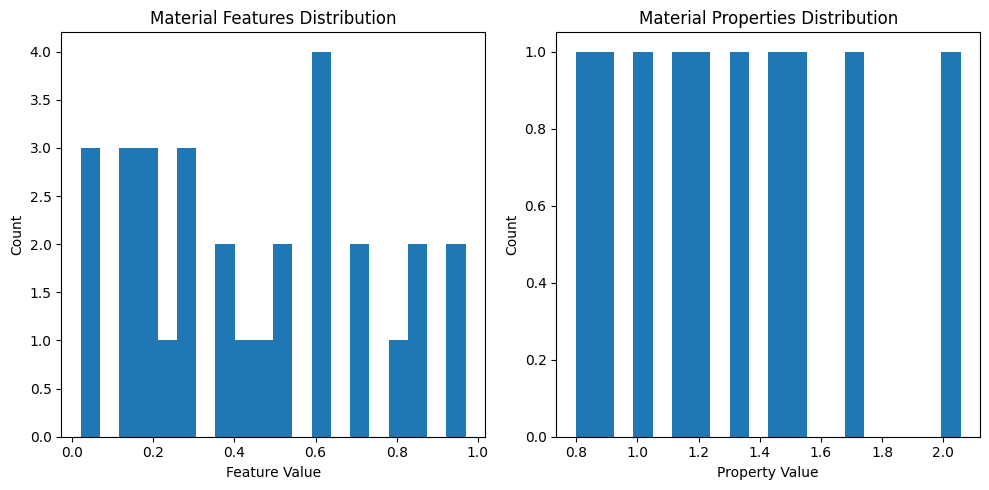


5. Classical Model Summary:


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 64)                  │             576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,689 (10.50 KB)

 Trainable params: 2,689 (10.50 KB)

 Non-trainable params: 0 (0.00 B)

In [7]:
import cirq
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
import matplotlib.pyplot as plt
import sympy

class QuantumMaterialsML:
    def __init__(self, n_qubits, n_properties):
        self.n_qubits = n_qubits
        self.n_properties = n_properties
        self.qubits = cirq.LineQubit.range(n_qubits)
        self.circuit = None
        self.params = []

    def create_quantum_circuit(self):
        """Create a parameterized quantum circuit for encoding material features"""
        circuit = cirq.Circuit()

        # Initial superposition
        circuit.append(cirq.H.on_each(self.qubits))

        # Parameterized rotation layers
        self.params = []
        for i in range(self.n_qubits):
            param_x = sympy.Symbol(f'θ_{i}_x')
            param_y = sympy.Symbol(f'θ_{i}_y')
            param_z = sympy.Symbol(f'θ_{i}_z')
            self.params.extend([param_x, param_y, param_z])

            circuit.append([
                cirq.rx(param_x)(self.qubits[i]),
                cirq.ry(param_y)(self.qubits[i]),
                cirq.rz(param_z)(self.qubits[i])
            ])

        # Entangling layers
        for i in range(self.n_qubits - 1):
            circuit.append(cirq.CNOT(self.qubits[i], self.qubits[i + 1]))

        self.circuit = circuit
        return circuit

    def encode_material_features(self, features):
        """Encode classical material features into quantum circuit parameters"""
        scaler = StandardScaler()
        normalized_features = scaler.fit_transform(features.reshape(-1, 1)).flatten() * np.pi

        param_values = {}
        for i, param in enumerate(self.params):
            if i < len(normalized_features):
                param_values[param] = float(normalized_features[i])  # Convert to float
            else:
                param_values[param] = 0.0

        return param_values

# Generate test data
np.random.seed(42)
n_samples = 10
features = np.random.rand(n_samples, 3)
properties = np.sum(features, axis=1).reshape(-1, 1)

print("=== Testing Quantum Materials ML Pipeline ===")
print("\n1. Generated Example Data:")
print(f"Features shape: {features.shape}")
print(f"Properties shape: {properties.shape}")
print("\nSample features (first 3):")
print(features[:3])

# Initialize model
n_qubits = 3
n_properties = 1
qml_model = QuantumMaterialsML(n_qubits=n_qubits, n_properties=n_properties)

# Create quantum circuit
circuit = qml_model.create_quantum_circuit()
print("\n2. Quantum Circuit Structure:")
print(circuit)

print("\n3. Circuit Diagram:")
print(circuit.to_text_diagram())

# Test feature encoding
print("\n4. Testing Feature Encoding:")
test_feature = features[0]
try:
    params = qml_model.encode_material_features(test_feature)
    print("Encoded quantum parameters for first sample:")
    for param, value in params.items():
        print(f"{param}: {value:.4f}")
except Exception as e:
    print(f"Error in feature encoding: {str(e)}")

# Visualize feature distribution
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Material Features Distribution")
plt.hist(features.flatten(), bins=20)
plt.xlabel("Feature Value")
plt.ylabel("Count")

plt.subplot(1, 2, 2)
plt.title("Material Properties Distribution")
plt.hist(properties.flatten(), bins=20)
plt.xlabel("Property Value")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# Create classical model for demonstration
def create_classical_model(input_dim, output_dim):
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(64, activation='relu', input_shape=(input_dim,)),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(output_dim, activation='linear')
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

print("\n5. Classical Model Summary:")
classical_model = create_classical_model(input_dim=2**n_qubits, output_dim=n_properties)
classical_model.summary()

=== Enhanced Quantum Materials ML Pipeline ===

1. Sample Data Statistics:
Features mean: 0.439
Features std: 0.278
Properties range: [0.798, 2.057]

2. Quantum Circuit Information:
Number of qubits: 3
Number of parameters: 9

Circuit Diagram:
0: ───H───Rx(θ_0_x)───Ry(θ_0_y)───Rz(θ_0_z)───@───────
                                              │
1: ───H───Rx(θ_1_x)───Ry(θ_1_y)───Rz(θ_1_z)───X───@───
                                                  │
2: ───H───Rx(θ_2_x)───Ry(θ_2_y)───Rz(θ_2_z)───────X───

3. Testing Feature Encoding:


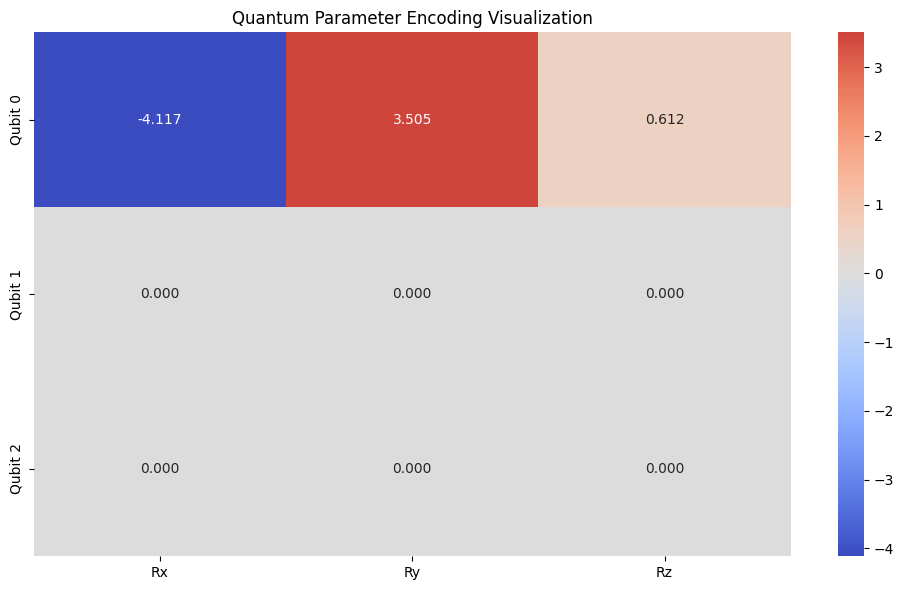


Encoded Parameters By Qubit:

Qubit 0:
  Rx: -4.1169
  Ry: 3.5051
  Rz: 0.6118

Qubit 1:
  Rx: 0.0000
  Ry: 0.0000
  Rz: 0.0000

Qubit 2:
  Rx: 0.0000
  Ry: 0.0000
  Rz: 0.0000


In [9]:
import cirq
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
import matplotlib.pyplot as plt
import sympy
import seaborn as sns

class QuantumMaterialsML:
    def __init__(self, n_qubits, n_properties):
        self.n_qubits = n_qubits
        self.n_properties = n_properties
        self.qubits = cirq.LineQubit.range(n_qubits)
        self.circuit = None
        self.params = []

    def create_quantum_circuit(self):
        circuit = cirq.Circuit()
        circuit.append(cirq.H.on_each(self.qubits))

        # Parameterized rotation layers with clearer parameter names
        self.params = []
        for i in range(self.n_qubits):
            param_x = sympy.Symbol(f'θ_{i}_x')
            param_y = sympy.Symbol(f'θ_{i}_y')
            param_z = sympy.Symbol(f'θ_{i}_z')
            self.params.extend([param_x, param_y, param_z])

            circuit.append([
                cirq.rx(param_x)(self.qubits[i]),
                cirq.ry(param_y)(self.qubits[i]),
                cirq.rz(param_z)(self.qubits[i])
            ])

        # Entangling layers
        for i in range(self.n_qubits - 1):
            circuit.append(cirq.CNOT(self.qubits[i], self.qubits[i + 1]))

        self.circuit = circuit
        return circuit

    def encode_material_features(self, features):
        """Encode classical material features into quantum circuit parameters with visualization"""
        scaler = StandardScaler()
        normalized_features = scaler.fit_transform(features.reshape(-1, 1)).flatten() * np.pi

        param_values = {}
        for i, param in enumerate(self.params):
            if i < len(normalized_features):
                param_values[param] = float(normalized_features[i])
            else:
                param_values[param] = 0.0

        # Visualize parameter encoding
        self.visualize_encoding(param_values)

        return param_values

    def visualize_encoding(self, param_values):
        """Visualize the quantum parameter encoding"""
        params_array = np.array(list(param_values.values())).reshape(self.n_qubits, 3)

        plt.figure(figsize=(10, 6))
        sns.heatmap(params_array,
                   xticklabels=['Rx', 'Ry', 'Rz'],
                   yticklabels=[f'Qubit {i}' for i in range(self.n_qubits)],
                   annot=True, fmt='.3f', cmap='coolwarm', center=0)
        plt.title('Quantum Parameter Encoding Visualization')
        plt.tight_layout()
        plt.show()

# Test the improved implementation
print("=== Enhanced Quantum Materials ML Pipeline ===\n")

# Generate test data
np.random.seed(42)
n_samples = 10
features = np.random.rand(n_samples, 3)
properties = np.sum(features, axis=1).reshape(-1, 1)

print("1. Sample Data Statistics:")
print(f"Features mean: {np.mean(features):.3f}")
print(f"Features std: {np.std(features):.3f}")
print(f"Properties range: [{np.min(properties):.3f}, {np.max(properties):.3f}]")

# Initialize and test model
n_qubits = 3
n_properties = 1
qml_model = QuantumMaterialsML(n_qubits=n_qubits, n_properties=n_properties)

# Create quantum circuit
circuit = qml_model.create_quantum_circuit()
print("\n2. Quantum Circuit Information:")
print(f"Number of qubits: {n_qubits}")
print(f"Number of parameters: {len(qml_model.params)}")
print("\nCircuit Diagram:")
print(circuit.to_text_diagram())

# Test feature encoding with visualization
print("\n3. Testing Feature Encoding:")
test_feature = features[0]
params = qml_model.encode_material_features(test_feature)

# Print all parameters in organized format
print("\nEncoded Parameters By Qubit:")
for i in range(n_qubits):
    print(f"\nQubit {i}:")
    print(f"  Rx: {params[qml_model.params[i*3]]:.4f}")
    print(f"  Ry: {params[qml_model.params[i*3+1]]:.4f}")
    print(f"  Rz: {params[qml_model.params[i*3+2]]:.4f}")

=== Quantum Materials Generator ===

1. Quantum Circuit Structure:
0: ───H───Rx(θ_0_0_x)───Ry(θ_0_0_y)───Rz(θ_0_0_z)───@───Rx(θ_1_0_x)───Ry(θ_1_0_y)───Rz(θ_1_0_z)─────────────────@───────
                                                    │                                                           │
1: ───H───Rx(θ_0_1_x)───Ry(θ_0_1_y)───Rz(θ_0_1_z)───X───@─────────────Rx(θ_1_1_x)───Ry(θ_1_1_y)───Rz(θ_1_1_z)───X───@───
                                                        │                                                           │
2: ───H───Rx(θ_0_2_x)───Ry(θ_0_2_y)───Rz(θ_0_2_z)───────X─────────────Rx(θ_1_2_x)───Ry(θ_1_2_y)───Rz(θ_1_2_z)───────X───

2. Target Bandgap: 1.5 eV

Starting material generation:

Attempt 1/5
Score: 0.6638
Properties: {'bandgap': 0.8072867393493652, 'stability': 0.6321982443332672}

Attempt 2/5
Score: 0.5681
Properties: {'bandgap': 0.8891894817352295, 'stability': 0.6100779175758362}

Attempt 3/5
Score: 1.6283
Properties: {'bandgap': 0.2508712410926819, '

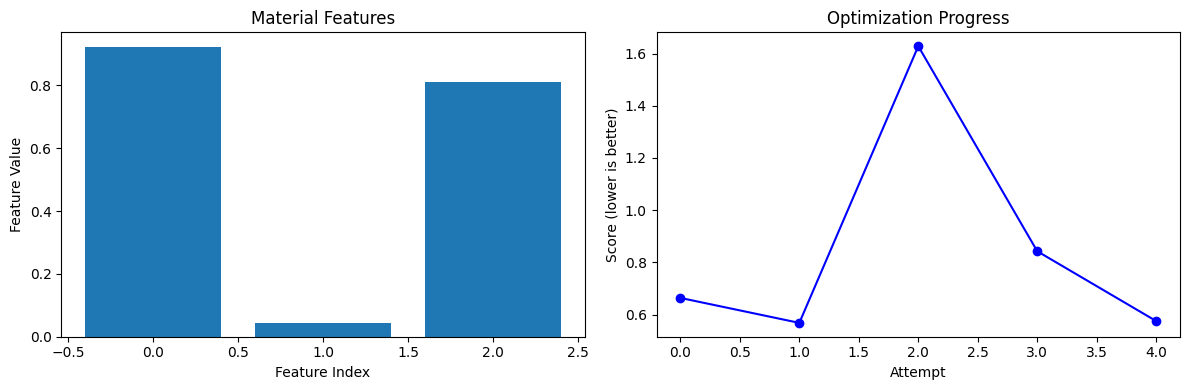

In [11]:
import cirq
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import tensorflow as tf
import matplotlib.pyplot as plt
import sympy
from scipy.optimize import minimize
import seaborn as sns

class QuantumMaterialsGenerator:
    def __init__(self, n_features=3, n_qubits=None):
        self.n_features = n_features
        self.n_qubits = n_qubits if n_qubits else n_features
        self.qubits = cirq.LineQubit.range(self.n_qubits)
        self.circuit = None
        self.params = []

        # Initialize scaler with dummy data
        self.feature_scaler = MinMaxScaler(feature_range=(-1, 1))
        dummy_data = np.random.rand(10, n_features)
        self.feature_scaler.fit(dummy_data)

    def create_variational_circuit(self):
        """Create a variational quantum circuit for material generation"""
        circuit = cirq.Circuit()

        # Initial superposition
        circuit.append(cirq.H.on_each(self.qubits))

        # Variational layers
        for layer in range(2):
            # Rotation gates
            for i in range(self.n_qubits):
                param_x = sympy.Symbol(f'θ_{layer}_{i}_x')
                param_y = sympy.Symbol(f'θ_{layer}_{i}_y')
                param_z = sympy.Symbol(f'θ_{layer}_{i}_z')
                self.params.extend([param_x, param_y, param_z])

                circuit.append([
                    cirq.rx(param_x)(self.qubits[i]),
                    cirq.ry(param_y)(self.qubits[i]),
                    cirq.rz(param_z)(self.qubits[i])
                ])

            # Entangling layers
            for i in range(self.n_qubits - 1):
                circuit.append(cirq.CNOT(self.qubits[i], self.qubits[i + 1]))

        self.circuit = circuit
        return circuit

    def quantum_to_material_features(self, quantum_params):
        """Convert quantum parameters to material features"""
        try:
            simulator = cirq.Simulator()
            resolved_circuit = cirq.resolve_parameters(
                self.circuit,
                {param: val for param, val in zip(self.params, quantum_params)}
            )

            # Get state vector using state_vector() method
            result = simulator.simulate(resolved_circuit)
            state_vector = result.state_vector()

            # Extract features from state vector
            features = np.real(state_vector[:self.n_features])
            # Normalize features to [-1, 1]
            features = features / np.max(np.abs(features))

            return self.feature_scaler.inverse_transform(features.reshape(1, -1))[0]

        except Exception as e:
            print(f"Error in quantum simulation: {str(e)}")
            return np.zeros(self.n_features)

    def predict_properties(self, features):
        """Predict material properties (placeholder for more sophisticated model)"""
        # Simple property model - can be replaced with trained ML model
        properties = {
            'bandgap': np.sum(features) * 0.5,  # Example property
            'stability': 1 - np.std(features)    # Example property
        }
        return properties

    def objective_function(self, quantum_params, target_properties):
        """Objective function for optimization"""
        features = self.quantum_to_material_features(quantum_params)
        predicted = self.predict_properties(features)

        # Calculate error based on main target property (bandgap)
        error = (predicted['bandgap'] - target_properties) ** 2

        # Add penalty for unstable configurations
        stability_penalty = (1 - predicted['stability']) * 0.5

        return error + stability_penalty

    def generate_novel_material(self, target_properties, n_attempts=5):
        """Generate novel material with desired properties"""
        best_material = None
        best_score = float('inf')
        all_attempts = []

        print("\nStarting material generation:")
        for attempt in range(n_attempts):
            print(f"\nAttempt {attempt + 1}/{n_attempts}")

            # Random initial parameters
            initial_params = np.random.uniform(-np.pi, np.pi, len(self.params))

            # Optimize parameters
            try:
                result = minimize(
                    self.objective_function,
                    initial_params,
                    args=(target_properties,),
                    method='BFGS',
                    options={'maxiter': 50}
                )

                current_material = self.quantum_to_material_features(result.x)
                current_properties = self.predict_properties(current_material)

                print(f"Score: {result.fun:.4f}")
                print(f"Properties: {current_properties}")

                if result.fun < best_score:
                    best_score = result.fun
                    best_material = current_material

                all_attempts.append({
                    'features': current_material,
                    'score': result.fun,
                    'properties': current_properties
                })

            except Exception as e:
                print(f"Optimization error in attempt {attempt + 1}: {str(e)}")
                continue

        return best_material, all_attempts

# Test the generator
print("=== Quantum Materials Generator ===")

# Initialize generator
generator = QuantumMaterialsGenerator(n_features=3)
circuit = generator.create_variational_circuit()

print("\n1. Quantum Circuit Structure:")
print(circuit)

# Set target properties (e.g., desired bandgap)
target_properties = 1.5
print(f"\n2. Target Bandgap: {target_properties} eV")

# Generate novel material
best_material, all_attempts = generator.generate_novel_material(target_properties)

if best_material is not None:
    print("\n3. Best Generated Material:")
    print(f"Features: {best_material}")
    print(f"Properties: {generator.predict_properties(best_material)}")

    # Visualize results
    plt.figure(figsize=(12, 4))

    # Plot feature values
    plt.subplot(1, 2, 1)
    plt.bar(range(len(best_material)), best_material)
    plt.title('Material Features')
    plt.xlabel('Feature Index')
    plt.ylabel('Feature Value')

    # Plot optimization progress
    plt.subplot(1, 2, 2)
    scores = [attempt['score'] for attempt in all_attempts]
    plt.plot(range(len(scores)), scores, 'bo-')
    plt.title('Optimization Progress')
    plt.xlabel('Attempt')
    plt.ylabel('Score (lower is better)')

    plt.tight_layout()
    plt.show()